/mnt/netapp2/Store_uni/home/usc/ci/avs/personal/aprendizaje/p4/venvP4/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Usando dispositivo: cuda
Valores faltantes: 0
Época 0: Loss 223296.5229
Época 10: Loss 55124.9419
Época 20: Loss 36620.2969
Época 30: Loss 34446.6026
Época 40: Loss 33549.1196
Época 50: Loss 32804.4217
Época 60: Loss 32369.0057
Época 70: Loss 32120.3937
Época 80: Loss 31534.6399
Época 90: Loss 31270.4508
Época 100: Loss 31035.6781
Época 110: Loss 30792.7700
Época 120: Loss 30534.1470
Época 130: Loss 30259.2017
Época 140: Loss 30154.8924
Época 150: Loss 29906.0992
Época 160: Loss 29794.9441
Época 170: Loss 29581.5977
Época 180: Loss 29388.2165
Época 190: Loss 29691.0724
Época 200: Loss 29073.6645
Época 210: Loss 28866.1853
Época 220: Loss 29105.4142
Época 230: Loss 28634.6697
Época 240: Loss 28536.7631
Época 250: Loss 28849.8564
Época 260: Loss 28784.1029
Época 270: Loss 28366.9029
Época 280: Loss 28196.1904
Época 290: Loss 28055.0709

--- Métricas ---
MAE: 31532.91
RMSE: 44749.41
R2: 0.9270
Modelo guardado como 'models/mlp_torch_model.pt'

Tiempo total: 529.76 s


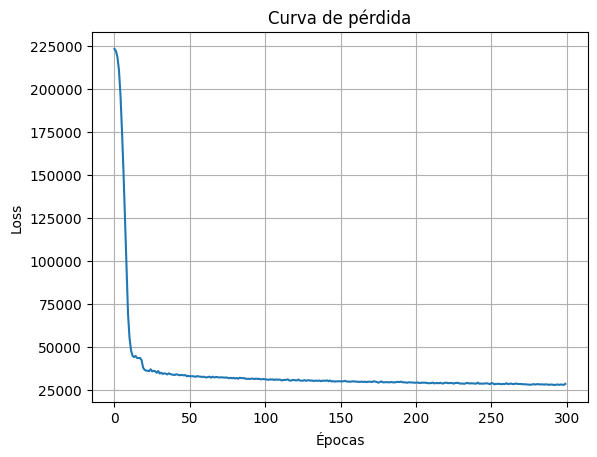

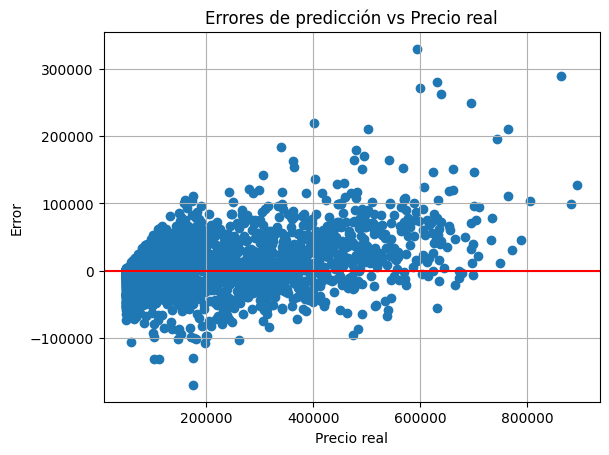

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import os
import joblib
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

# Create directories
os.makedirs('models', exist_ok=True)
os.makedirs('results_mlp', exist_ok=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {device}")

def load_data(file_path):
    df = pd.read_csv(file_path)
    print(f"Valores faltantes: {df.isnull().sum().sum()}")
    categorical_features = [col for col in df.columns if 'tipo_' in col or 'color_' in col]
    X = df.drop(['prezo_euros', 'id'], axis=1, errors='ignore')
    y = df['prezo_euros']
    return X, y, categorical_features

class MLPRegressorTorch(nn.Module):
    def __init__(self, input_dim):
        super(MLPRegressorTorch, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.BatchNorm1d(256),
            nn.SiLU(),
            nn.Dropout(0.25),

            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.SiLU(),

            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.SiLU(),

            nn.Linear(64, 32),
            nn.SiLU(),

            nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.model(x)

def train_torch_model(X, y, epochs=300, batch_size=64, lr=0.001):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    joblib.dump(scaler, 'models/mlp_scaler.pkl')

    # Convert to tensors
    X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train.values.reshape(-1, 1), dtype=torch.float32)
    X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test.values.reshape(-1, 1), dtype=torch.float32)

    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    model = MLPRegressorTorch(X.shape[1]).to(device)
    criterion = nn.L1Loss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    losses = []
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        avg_loss = running_loss / len(train_loader)
        losses.append(avg_loss)
        if epoch % 10 == 0:
            print(f"Época {epoch}: Loss {avg_loss:.4f}")

    # Evaluation
    model.eval()
    with torch.no_grad():
        predictions = model(X_test_tensor.to(device)).cpu().numpy().flatten()
    mae = mean_absolute_error(y_test, predictions)
    rmse = np.sqrt(mean_squared_error(y_test, predictions))
    r2 = r2_score(y_test, predictions)

    print(f"\n--- Métricas ---\nMAE: {mae:.2f}\nRMSE: {rmse:.2f}\nR2: {r2:.4f}")

    # Save model
    torch.save(model.state_dict(), 'models_stacking/mlp_torch_model.pt')
    print("Modelo guardado como 'models/mlp_torch_model.pt'")

    # Loss curve
    plt.figure()
    plt.plot(losses)
    plt.title("Curva de pérdida")
    plt.xlabel("Épocas")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.savefig("results_mlp/mlp_loss_curve.png")

    # Error analysis
    errors = y_test.values - predictions
    plt.figure()
    plt.scatter(y_test.values, errors)
    plt.axhline(0, color='r')
    plt.title("Errores de predicción vs Precio real")
    plt.xlabel("Precio real")
    plt.ylabel("Error")
    plt.grid(True)
    plt.savefig("results_mlp/mlp_error_analysis.png")

    return model

if __name__ == "__main__":
    start = time.time()
    X, y, _ = load_data('train_processed.csv')
    model = train_torch_model(X, y)
    print(f"\nTiempo total: {time.time() - start:.2f} s")
